# LangGraph 101: Conditional Routing


## Imports and State Definition


In [39]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## State Definition


In [29]:
class NumberState(TypedDict):
    number: int
    result: int

## Node Functions and Router

We've set up three processing nodes to handle different types of numbers:

- **Positive numbers**: We square the number.
- **Negative numbers**: We take the absolute value.
- **Zero**: We leave it as zero.

Additionally, we've built a router function that decides which path to follow based on the sign of the input number.


In [ ]:
def square_node(state: NumberState) -> NumberState:
    """If positive: square the number"""
    state["result"] = state["number"] ** 2
    return state


def abs_node(state: NumberState) -> NumberState:
    """If negative: take absolute value"""
    state["result"] = abs(state["number"])
    return state


In [ ]:
def zero_node(state: NumberState) -> NumberState:
    """If zero: leave as zero"""
    state["result"] = 0
    return state


def route_by_sign(state: NumberState) -> str:
    """Choose next node based on the sign of the number"""
    if state["number"] > 0:
        return "positive_branch"
    elif state["number"] < 0:
        return "negative_branch"
    else:
        return "zero_branch"

## Building the Conditional Routing Graph

1.  Start → Router node
2.  Router evaluates the number's sign
3.  Routes to the appropriate processing node
4.  All branches lead to END


In [31]:
# Build the graph
graph = StateGraph(NumberState)

# Add our transformation nodes
graph.add_node("square_node", square_node)
graph.add_node("abs_node", abs_node)
graph.add_node("zero_node", zero_node)

# A passthrough router node
graph.add_node("router", lambda s: s)

# Link start → router
graph.add_edge(START, "router")

# Conditional edges from router into each branch
graph.add_conditional_edges(
    "router",
    route_by_sign,
    {"positive_branch": "square_node", "negative_branch": "abs_node", "zero_branch": "zero_node"},
)

# All branches lead to END
graph.add_edge("square_node", END)
graph.add_edge("abs_node", END)
graph.add_edge("zero_node", END)

# Compile into an executable app
app = graph.compile()

## Visualizing the Graph


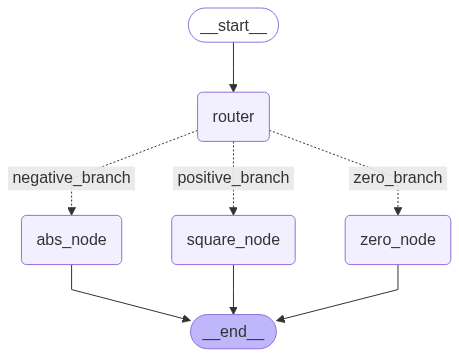

In [ ]:
graph_img = Image(app.get_graph().draw_mermaid_png())
display(graph_img)
# save the graph to a file
with open("../output/05-Conditional_Routing.png", "wb") as f:
    f.write(app.get_graph().draw_mermaid_png())
# Mermaid is a popular diagramming syntax that can be rendered in many tools
with open("../output/05-Conditional_Routing.mmd", "w") as f:
    f.write(app.get_graph().draw_mermaid())

## Testing the Conditional Routing Graph


In [33]:
# Test it out:
for test_number in [5, -3, 0]:
    state: NumberState = {"number": test_number, "result": None}  # type: ignore
    out = app.invoke(state)
    print(f"Input: {test_number:>2} → Result: {out['result']}")

Input:  5 → Result: 25
Input: -3 → Result: 3
Input:  0 → Result: 0


---

# Example 2: Text Message Processing Router

Let's create another conditional routing example using text messages. This will demonstrate how to route based on text length and apply different processing strategies.


## Text State Definition


In [34]:
class MessageState(TypedDict):
    message: str
    processed_message: str
    word_count: int

## Text Processing Nodes and Router

We'll route messages based on their length and apply different processing:

- **Short messages** (≤ 10 chars): Convert to uppercase and add exclamation
- **Medium messages** (11-50 chars): Add a friendly greeting prefix
- **Long messages** (> 50 chars): Summarize by counting words and truncating


In [ ]:
def short_message_node(state: MessageState) -> MessageState:
    """Process short messages: make them loud and exciting"""
    state["processed_message"] = state["message"].upper() + "!"
    state["word_count"] = len(state["message"].split())
    return state


def medium_message_node(state: MessageState) -> MessageState:
    """Process medium messages: add friendly greeting"""
    state["processed_message"] = f"Hello! {state['message']}"
    state["word_count"] = len(state["message"].split())
    return state


In [ ]:
def long_message_node(state: MessageState) -> MessageState:
    """Process long messages: truncate and count words"""
    words = state["message"].split()
    state["word_count"] = len(words)
    # Truncate to first 50 characters and add summary
    truncated = state["message"][:50] + "..." if len(state["message"]) > 50 else state["message"]
    state["processed_message"] = f"{truncated} [{state['word_count']} words]"
    return state


def route_by_length(state: MessageState) -> str:
    """Choose processing strategy based on message length"""
    message_length = len(state["message"])

    if message_length <= 10:
        return "short_path"
    elif message_length <= 50:
        return "medium_path"
    else:
        return "long_path"

## Building the Text Processing Graph


In [36]:
# Build the text processing graph
text_graph = StateGraph(MessageState)

# Add our text processing nodes
text_graph.add_node("short_processor", short_message_node)
text_graph.add_node("medium_processor", medium_message_node)
text_graph.add_node("long_processor", long_message_node)

# Router node (passthrough)
text_graph.add_node("text_router", lambda s: s)

# Link start → router
text_graph.add_edge(START, "text_router")

# Conditional edges from router to processing nodes
text_graph.add_conditional_edges(
    "text_router",
    route_by_length,
    {"short_path": "short_processor", "medium_path": "medium_processor", "long_path": "long_processor"},
)

# All processors lead to END
text_graph.add_edge("short_processor", END)
text_graph.add_edge("medium_processor", END)
text_graph.add_edge("long_processor", END)

# Compile the text processing app
text_app = text_graph.compile()

## Visualizing the Text Processing Graph


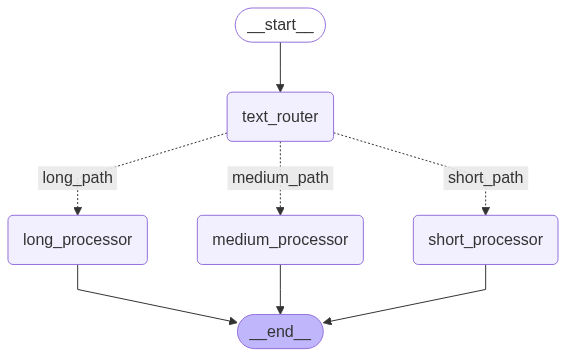

In [37]:
# Visualize the text processing graph
text_graph_img = Image(text_app.get_graph().draw_mermaid_png())
display(text_graph_img)

# Save the text processing graph
with open("../output/05-Text_Routing.png", "wb") as f:
    f.write(text_app.get_graph().draw_mermaid_png())

with open("../output/05-Text_Routing.mmd", "w") as f:
    f.write(text_app.get_graph().draw_mermaid())

## Testing the Text Processing Router


In [38]:
# Test different message lengths
test_messages = [
    "Hi!",  # Short (3 chars)
    "How are you doing today?",  # Medium (25 chars)
    "This is a really long message that should definitely be truncated because it contains way too much information for a simple greeting.",  # Long (134 chars)
]

print("Text Processing Results:")
print("=" * 50)

for msg in test_messages:
    state: MessageState = {"message": msg, "processed_message": "", "word_count": 0}
    result = text_app.invoke(state)

    print(f"Original ({len(msg)} chars): {msg}")
    print(f"Processed: {result['processed_message']}")
    print(f"Word count: {result['word_count']}")
    print("-" * 30)

Text Processing Results:
Original (3 chars): Hi!
Processed: HI!!
Word count: 1
------------------------------
Original (24 chars): How are you doing today?
Processed: Hello! How are you doing today?
Word count: 5
------------------------------
Original (133 chars): This is a really long message that should definitely be truncated because it contains way too much information for a simple greeting.
Processed: This is a really long message that should definite... [22 words]
Word count: 22
------------------------------
